### Imports

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules
import pickle
from itertools import combinations
import networkx as nx
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

### Read Data

In [3]:
transactions = pd.read_csv("transactions_train.csv")
articles = pd.read_csv("articles.csv")

In [4]:
articles.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [5]:
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [6]:
# Check date-timeframe
print(transactions.t_dat.min())
print(transactions.t_dat.max())

2018-09-20
2020-09-22


### EDA

In [ ]:
## First let's merge the articles file (section_name, department_name, and prod_name) so we can group the data by those categories
trans_merge = pd.merge(transactions, articles[["article_id", "prod_name", "department_name", "section_name"]], on="article_id")
trans_merge["t_dat"] = pd.to_datetime(trans_merge["t_dat"], infer_datetime_format=True)

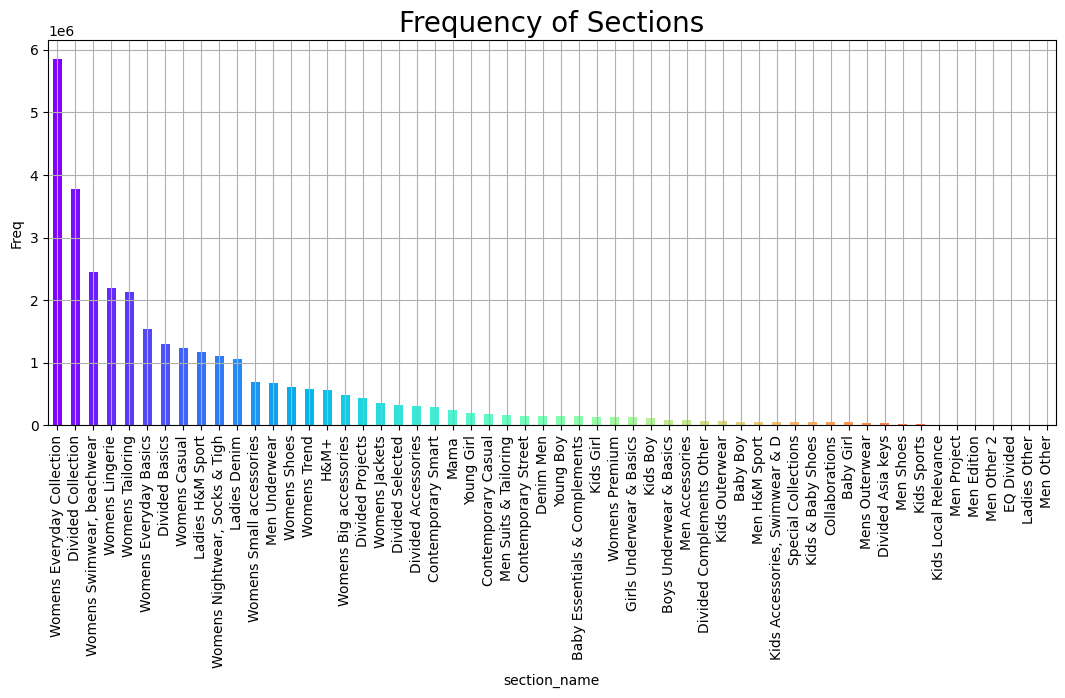

In [70]:
#trans_merge.section_name.value_counts().plot.bar()
color = plt.cm.rainbow(np.linspace(0, 1, 56))
trans_merge.section_name.value_counts().plot.bar(color = color, figsize=(13,5))
plt.title('Frequency of Sections', fontsize = 20)
plt.ylabel('Freq')
plt.xticks(rotation = 90)
plt.grid()
plt.show()

### Data Prep

In [16]:
# There is no transaction ID, but we can group by customer_id and date to form transactions on the same day
transactions = trans_merge.groupby(by=['t_dat','customer_id'])['section_name'].apply(list).tolist()

# Display the first few transactions to inspect the format
transactions[:2]

[['Womens Lingerie', 'Womens Lingerie'],
 ['Divided Selected',
  'Womens Everyday Collection',
  'Womens Everyday Collection',
  'Womens Everyday Collection',
  'Divided Selected']]

In [17]:
# We have 9M transactions
len(transactions)

9080179

In [48]:
# Create sparse matrix
te = TransactionEncoder()
oht_ary = te.fit(transactions).transform(transactions, sparse=True)
sparse_df = pd.DataFrame.sparse.from_spmatrix(oht_ary, columns=te.columns_)

C:\Users\Blake\AppData\Local\Temp\ipykernel_23752\2842661945.py:2: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  sparse_df = pd.DataFrame.sparse.from_spmatrix(oht_ary, columns=te.columns_)


In [41]:
# fpgrowth ran a little faster than apripori
fp_df = fpgrowth(sparse_df, min_support=0.00000001, use_colnames=True, max_len=3)

In [2]:
# Save df with results (Optional)

#with open('fp_df.pkl', 'wb') as fileObj:
#    pickle.dump(fp_df,fileObj)

#with open('fp_df.pkl', 'rb') as fileObj:
#    fp_df = pickle.load(fileObj)

### Results Prep

In [3]:
# Display itemsets by support
fp_df['length'] = fp_df['itemsets'].apply(lambda x: len(x))
fp_df

,support,itemsets,length
0,1.141709e-01,(Womens Lingerie),1
1,3.468482e-01,(Womens Everyday Collection),1
2,2.781906e-02,(Divided Selected),1
3,1.457564e-01,(Womens Tailoring),1
4,2.281546e-01,(Divided Collection),1
...,...,...,...
25960,1.101300e-07,"(Ladies Other, Womens Premium, Kids & Baby Shoes)",3
25961,1.101300e-07,"(Womens Casual, Ladies Other, Kids & Baby Shoes)",3
25962,1.101300e-07,"(Womens Tailoring, Ladies Other, Kids & Baby S...",3
25963,1.101300e-07,"(Divided Collection, Ladies Other, Kids & Baby...",3


In [4]:
# Filter to 2 items pairs
fp_df.loc[fp_df.length == 2,].sort_values(by='support', ascending = False)

,support,itemsets,length
275,8.838581e-02,"(Divided Collection, Womens Everyday Collection)",2
273,6.640078e-02,"(Womens Tailoring, Womens Everyday Collection)",2
8471,4.747946e-02,"(Womens Casual, Womens Everyday Collection)",2
4261,4.520649e-02,"(Womens Everyday Basics, Womens Everyday Colle...",2
276,3.591724e-02,"(Divided Basics, Divided Collection)",2
...,...,...,...
21647,1.101300e-07,"(Men Other 2, EQ Divided)",2
23559,1.101300e-07,"(Kids Outerwear, Men Other)",2
23560,1.101300e-07,"(Girls Underwear & Basics, Men Other)",2
23540,1.101300e-07,"(Men Other, Kids Accessories, Swimwear & D)",2


In [5]:
# Total number of two-way comparisons
56*(55)/2

1540.0

In [6]:
# Calculate other associate rule metrics
fp_rules = association_rules(fp_df, metric="lift", min_threshold=.001)
fp_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Womens Lingerie),(Divided Collection),0.114171,2.281546e-01,2.156896e-02,1.889182e-01,0.828027,-4.479658e-03,0.951625,-0.189928
1,(Divided Collection),(Womens Lingerie),0.228155,1.141709e-01,2.156896e-02,9.453657e-02,0.828027,-4.479658e-03,0.978316,-0.212029
2,(Womens Tailoring),(Womens Lingerie),0.145756,1.141709e-01,1.301858e-02,8.931737e-02,0.782313,-3.622558e-03,0.972709,-0.245704
3,(Womens Lingerie),(Womens Tailoring),0.114171,1.457564e-01,1.301858e-02,1.140271e-01,0.782313,-3.622558e-03,0.964187,-0.239037
4,(Womens Lingerie),(Womens Everyday Collection),0.114171,3.468482e-01,3.039577e-02,2.662305e-01,0.767571,-9.204200e-03,0.890132,-0.254755
...,...,...,...,...,...,...,...,...,...,...
149341,"(Ladies Other, Womens Everyday Collection)",(Kids & Baby Shoes),0.000062,3.464029e-03,1.101300e-07,1.776199e-03,0.512755,-1.046508e-07,0.998309,-0.487260
149342,"(Womens Everyday Collection, Kids & Baby Shoes)",(Ladies Other),0.000646,9.812582e-05,1.101300e-07,1.705030e-04,1.737596,4.674931e-08,1.000072,0.424766
149343,(Ladies Other),"(Womens Everyday Collection, Kids & Baby Shoes)",0.000098,6.459124e-04,1.101300e-07,1.122334e-03,1.737596,4.674931e-08,1.000477,0.424534
149344,(Kids & Baby Shoes),"(Ladies Other, Womens Everyday Collection)",0.003464,6.200318e-05,1.101300e-07,3.179246e-05,0.512755,-1.046508e-07,0.999970,-0.488112


In [7]:
# Filter to two item pairs
fp_rules['ant_length'] = fp_rules['antecedents'].apply(lambda x: len(x))
fp_rules['con_length'] = fp_rules['consequents'].apply(lambda x: len(x))
fp_rules['length'] = fp_rules['ant_length'] + fp_rules['con_length']
fp_rules_2item = fp_rules.loc[fp_rules.length == 2,]

In [8]:
# dedup results so we only have 1 directional rules

# Creating a new column with sets of 'antecedents' and 'consequents'
fp_rules_2item['combined'] = fp_rules_2item.apply(lambda row: frozenset([row['antecedents'], row['consequents']]), axis=1)

# Dropping duplicates based on the 'combined' column
fp_rules_2item = fp_rules_2item.drop_duplicates(subset=['combined']).drop(columns=['combined', 'conviction', 'zhangs_metric', 'ant_length', 'con_length', 'length'])
fp_rules_2item['antecedents'] = fp_rules_2item['antecedents'].apply(lambda x: ', '.join(x))
fp_rules_2item['consequents'] = fp_rules_2item['consequents'].apply(lambda x: ', '.join(x))




C:\Users\Blake\AppData\Local\Temp\ipykernel_27380\574482677.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fp_rules_2item['combined'] = fp_rules_2item.apply(lambda row: frozenset([row['antecedents'], row['consequents']]), axis=1)


### Most Frequent Pairs

##### Highest Lift

In [9]:
fp_rules_2item_lift = fp_rules_2item.sort_values(by='lift', ascending = False)
fp_rules_2item_lift[["antecedents", "consequents", "support", "lift"]].iloc[:10]

,antecedents,consequents,support,lift
128688,Men Other 2,Men Edition,0.000007,69.642006
41832,Baby Girl,Baby Essentials & Complements,0.001071,44.241461
139104,Men Project,Men Edition,0.000009,42.300274
9082,Baby Boy,Baby Essentials & Complements,0.001136,39.789033
55690,Young Boy,Boys Underwear & Basics,0.001476,37.149014
55686,Boys Underwear & Basics,Kids Boy,0.001163,36.773589
128712,Men Other 2,Men Project,0.000006,32.604944
37162,Kids Girl,Girls Underwear & Basics,0.001415,31.722922
34492,Young Girl,Girls Underwear & Basics,0.002269,31.270417
128640,Men Suits & Tailoring,Men Other 2,0.000097,30.659598


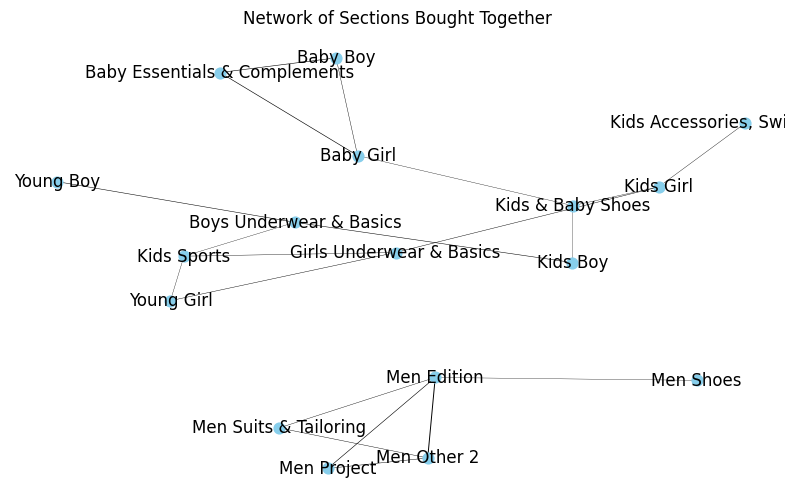

In [13]:
# Create network plot

G=nx.from_pandas_edgelist(fp_rules_2item_lift.iloc[0:20], 'antecedents', 'consequents', 'lift')

np.random.seed(10)

plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, k=0.25, iterations=15)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos, node_size=60, node_color="skyblue")

# edges
for (u, v, d) in G.edges(data=True):
    nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=d['lift'] / 100)

# labels
nx.draw_networkx_labels(G, pos, font_size=12, font_family="sans-serif")

plt.title("Network of Sections Bought Together")
plt.axis("off")
plt.show()

# Displaying the graph
plt.show()


##### Highest Leverage

In [14]:
fp_rules_2item_lev = fp_rules_2item.sort_values(by='leverage', ascending = False)
fp_rules_2item_lev[["antecedents", "consequents", "support", "leverage"]].iloc[:10]

,antecedents,consequents,support,leverage
1206,Womens Tailoring,Womens Everyday Collection,0.066401,0.015845
48158,Womens Casual,Womens Everyday Collection,0.047479,0.015390
1216,Divided Basics,Divided Collection,0.035917,0.015265
1214,Divided Collection,Womens Everyday Collection,0.088386,0.009251
24098,Womens Everyday Basics,Womens Everyday Collection,0.045206,0.009201
48156,Womens Casual,Womens Everyday Basics,0.018780,0.009176
1222,Divided Basics,Womens Everyday Basics,0.018042,0.008646
48162,Womens Casual,Divided Collection,0.029076,0.007967
2388,Divided Collection,Divided Projects,0.015305,0.007235
40406,Ladies Denim,Divided Collection,0.024239,0.007192


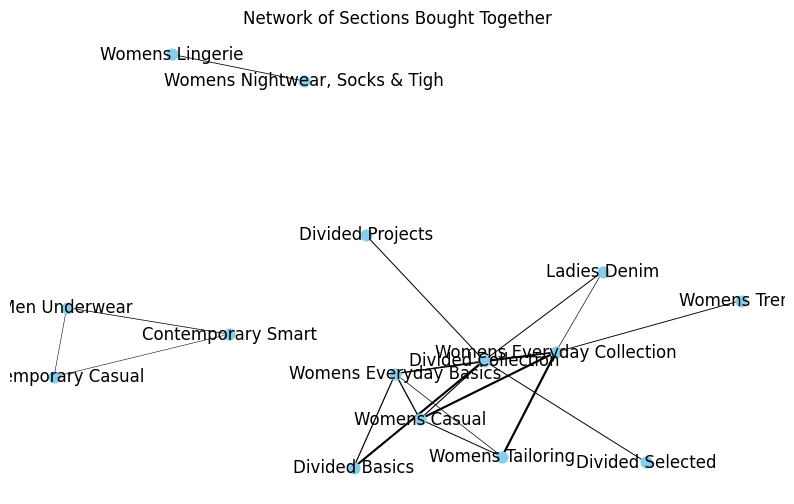

In [16]:

G=nx.from_pandas_edgelist(fp_rules_2item_lev.iloc[0:20], 'antecedents', 'consequents', 'leverage')

np.random.seed(6)

plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, k=0.3, iterations=15)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos, node_size=60, node_color="skyblue")

# edges
for (u, v, d) in G.edges(data=True):
    nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=d['leverage']*100)

# labels
nx.draw_networkx_labels(G, pos, font_size=12, font_family="sans-serif")

plt.title("Network of Sections Bought Together")
plt.axis("off")
plt.show()

# Displaying the graph
plt.show()


### Least Frequent Pairs

##### Never Seen Pairs

In [17]:
# Determine which 2 item pairs never occur

temp_2item_df = fp_rules.loc[fp_rules.length == 2,]

# Generate all possible pair combinations of these unique items (order doesn't matter)
unique_items = set(temp_2item_df['antecedents']).union(set(temp_2item_df['consequents']))

all_possible_pairs = set(combinations(unique_items, 2))

pairs_present = set(temp_2item_df.apply(lambda row: (row['antecedents'], row['consequents']), axis=1))

# Recalculate pairs not present in the data.
pairs_not_present = all_possible_pairs - pairs_present

# Displaying pairs not present in the data and their count.
pd.DataFrame(pairs_not_present)

,0,1
0,(Kids Local Relevance),(Men Other)
1,(Men Project),(Ladies Other)
2,(Men Other),(EQ Divided)
3,(Baby Girl),(EQ Divided)
4,(Men Project),(Men Other)
5,(Kids Sports),(Men Other)
6,(Kids & Baby Shoes),(Men Other)
7,(Men Other 2),(Ladies Other)
8,(Kids Boy),(Men Other)
9,(Mens Outerwear),(EQ Divided)


##### Lowest Lift

In [18]:
fp_rules_2item_lift_least = fp_rules_2item.sort_values(by='lift', ascending = True)
fp_rules_2item_lift_least[["antecedents", "consequents", "support", "lift"]].iloc[:10]

,antecedents,consequents,support,lift
135368,Girls Underwear & Basics,Men Other,1.101300e-07,0.164970
67000,"Womens Swimwear, beachwear",Mens Outerwear,5.803850e-05,0.181562
128740,Men Other 2,Divided Complements Other,3.303900e-07,0.189010
59608,Divided Complements Other,Kids & Baby Shoes,4.515329e-06,0.231180
139194,Divided Complements Other,Men Edition,4.405200e-07,0.243117
135332,Young Girl,Men Other,2.202600e-07,0.246686
51700,"Womens Swimwear, beachwear",Kids Outerwear,1.059450e-04,0.252593
51718,Kids Outerwear,Divided Complements Other,6.828059e-06,0.257486
135366,Kids Outerwear,Men Other,1.101300e-07,0.258354
108444,Divided Complements Other,Mama,1.530807e-05,0.262409


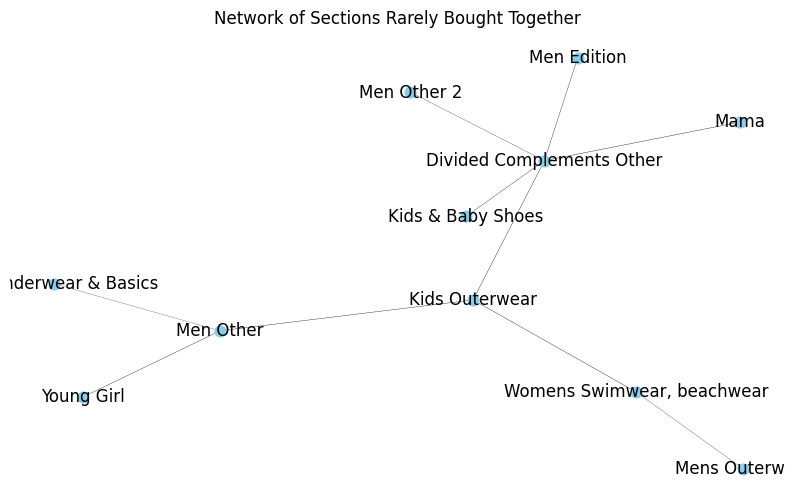

In [19]:


G=nx.from_pandas_edgelist(fp_rules_2item_lift_least.iloc[0:10], 'antecedents', 'consequents', 'lift')

np.random.seed(7)

plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, k=0.25, iterations=15)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos, node_size=60, node_color="skyblue")

# edges
for (u, v, d) in G.edges(data=True):
    nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=d['lift'])

# labels
nx.draw_networkx_labels(G, pos, font_size=12, font_family="sans-serif")

plt.title("Network of Sections Rarely Bought Together")
plt.axis("off")
plt.show()

# Displaying the graph
plt.show()

##### Lowest Leverage

In [20]:
fp_rules_2item_lev_least = fp_rules_2item.sort_values(by='leverage', ascending = True)
fp_rules_2item_lev_least[["antecedents", "consequents", "support", "leverage"]].iloc[:10]

,antecedents,consequents,support,leverage
4,Womens Lingerie,Womens Everyday Collection,0.030396,-0.009204
50076,"Womens Swimwear, beachwear",Womens Everyday Collection,0.023208,-0.007724
24142,Ladies H&M Sport,Womens Everyday Collection,0.015715,-0.006519
64740,Men Underwear,Womens Everyday Collection,0.007103,-0.006314
50078,Womens Tailoring,"Womens Swimwear, beachwear",0.008223,-0.004776
0,Womens Lingerie,Divided Collection,0.021569,-0.004480
2,Womens Tailoring,Womens Lingerie,0.013019,-0.003623
24146,Ladies H&M Sport,Divided Collection,0.011074,-0.003551
64736,Divided Collection,Men Underwear,0.005305,-0.003520
50084,"Womens Swimwear, beachwear",Divided Collection,0.017137,-0.003211


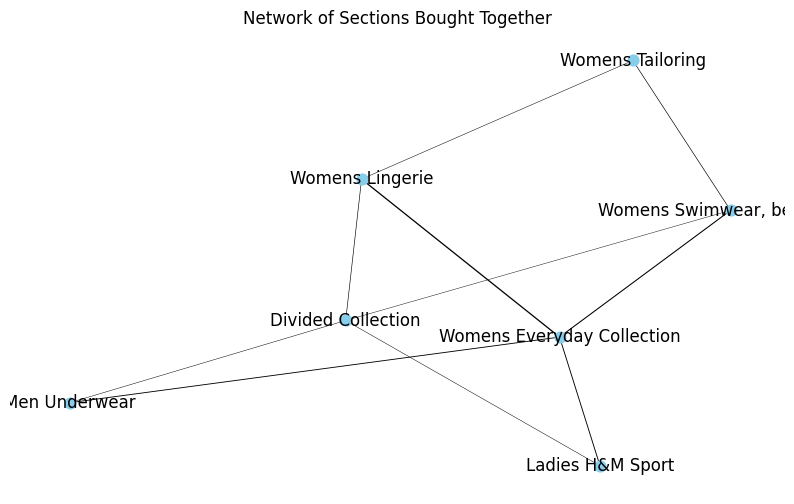

In [21]:

G=nx.from_pandas_edgelist(fp_rules_2item_lev_least.iloc[0:10], 'antecedents', 'consequents', 'leverage')

np.random.seed(7)

plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, k=0.3, iterations=15)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos, node_size=60, node_color="skyblue")

# edges
for (u, v, d) in G.edges(data=True):
    nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=d['leverage']*100)

# labels
nx.draw_networkx_labels(G, pos, font_size=12, font_family="sans-serif")

plt.title("Network of Sections Bought Together")
plt.axis("off")
plt.show()

# Displaying the graph
plt.show()


### Bonus Strategy

In [22]:
## Womens Everyday Collection is most popular. Find sections with highest lift, and locate them next to Womens Everyday in order to boost sales


fp_rules_2item_test = fp_rules.loc[fp_rules.length == 2,]
fp_rules_2item_test.loc[fp_rules_2item_test['antecedent support'] > 0.3].sort_values(by='lift', ascending = False).iloc[:10]



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,ant_length,con_length,length
145697,(Womens Everyday Collection),(Ladies Other),0.346848,0.000098,0.000062,0.000179,1.821760,0.000028,1.000081,0.690621,1,1,2
124201,(Womens Everyday Collection),(EQ Divided),0.346848,0.000167,0.000096,0.000278,1.661579,0.000038,1.000111,0.609602,1,1,2
48159,(Womens Everyday Collection),(Womens Casual),0.346848,0.092519,0.047479,0.136888,1.479575,0.015390,1.051407,0.496256,1,1,2
1319,(Womens Everyday Collection),(Womens Trend),0.346848,0.045046,0.022160,0.063890,1.418341,0.006536,1.020131,0.451581,1,1,2
118361,(Womens Everyday Collection),(Divided Asia keys),0.346848,0.002535,0.001247,0.003595,1.417882,0.000367,1.001063,0.451231,1,1,2
48233,(Womens Everyday Collection),(Womens Premium),0.346848,0.010317,0.004901,0.014131,1.369676,0.001323,1.003869,0.413227,1,1,2
1207,(Womens Everyday Collection),(Womens Tailoring),0.346848,0.145756,0.066401,0.191440,1.313428,0.015845,1.056501,0.365357,1,1,2
2386,(Womens Everyday Collection),(Divided Projects),0.346848,0.035372,0.015791,0.045528,1.287117,0.003523,1.010640,0.341528,1,1,2
25,(Womens Everyday Collection),(Divided Selected),0.346848,0.027819,0.012342,0.035582,1.279057,0.002693,1.008050,0.334033,1,1,2
24099,(Womens Everyday Collection),(Womens Everyday Basics),0.346848,0.103808,0.045206,0.130335,1.255545,0.009201,1.030503,0.311617,1,1,2
